In [1]:
import json

file_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/train.jsonl'

# 存储所有数据的列表
train_data = []
with open(file_path, 'r') as f:
    for line in f:
        train_data.append(json.loads(line.strip()))

In [31]:
import spacy
# Load English language model
nlp = spacy.load("en_core_web_sm")
# Function to analyze core sentence structure
def analyze_core_structure(tokens):
    # Join tokens into sentence
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Get the first sentence
    sent = next(doc.sents)
    
    # Get the root verb
    root = [token for token in sent if token.head == token][0]
    
    # Extract core components
    structure = {
        'root': {
            'text': root.text,
            'pos': root.pos_
        },
        'subject': None,  # 句子的主语（例如名词短语）
        'object': None,   # 句子的宾语（例如直接/间接宾语）
        'modifier': None  # 修饰语（例如副词/形容词）
    }
    
    # Find main subject and object
    for token in sent:
        # Subject
        if token.dep_ in ('nsubj', 'nsubjpass'):
            structure['subject'] = {
                'text': token.text,
                'pos': token.pos_
            }
        # Object 
        elif token.dep_ in ('dobj', 'pobj'):
            structure['object'] = {
                'text': token.text,
                'pos': token.pos_
            }
        # Main modifier
        elif token.dep_ in ('amod', 'advmod') and token.head == root:
            structure['modifier'] = {
                'text': token.text,
                'pos': token.pos_
            }
            
    # Create pattern string
    pattern = f"ROOT:{root.pos_}"
    if structure['subject']:
        pattern += f"_SUBJ:{structure['subject']['pos']}"
    if structure['object']:
        pattern += f"_OBJ:{structure['object']['pos']}" 
    if structure['modifier']:
        pattern += f"_MOD:{structure['modifier']['pos']}"
        
    return pattern

# Function to analyze complete sentence structure
def analyze_complete_structure(tokens):
    # Join tokens into sentence
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Get the first sentence
    sent = next(doc.sents)
    
    # Get the root verb
    root = [token for token in sent if token.head == token][0]
    
    # Extract core components
    structure = {
        'root': {
            'text': root.text,
            'pos': root.pos_,
            'dep': root.dep_
        },
        'subject': [],  # 主语
        'object': [],   # 宾语
        'modifier': [], # 修饰语
        'compound': [], # 复合词
        'prep': [],     # 介词
        'cc': [],       # 并列连词
        'conj': []      # 连词
    }
    
    # Find all dependencies
    for token in sent:
        if token != root:
            # Core arguments
            if token.dep_ in ('nsubj', 'nsubjpass'):
                structure['subject'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            elif token.dep_ in ('dobj', 'pobj'):
                structure['object'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            elif token.dep_ in ('amod', 'advmod') and token.head == root:
                structure['modifier'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            # Additional dependencies
            elif token.dep_ == 'compound':
                structure['compound'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            elif token.dep_ == 'prep':
                structure['prep'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            elif token.dep_ == 'cc':
                structure['cc'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            elif token.dep_ == 'conj':
                structure['conj'].append({
                    'text': token.text,
                    'pos': token.pos_,
                    'head': token.head.text
                })
            
    # Create detailed pattern string
    pattern = f"ROOT:{root.pos_}_{root.dep_}"
    
    # Add all dependencies to pattern
    for dep_type in ['subject', 'object', 'modifier', 'compound', 'prep', 'cc', 'conj']:
        if structure[dep_type]:
            pattern += f"_{dep_type.upper()}:"
            pattern += "+".join([f"{dep['pos']}" for dep in structure[dep_type]])
            
    return pattern

In [33]:
import collections
from tqdm import tqdm

# Analyze all comment tokens
structure_counts = collections.Counter()
sentence_patterns = {}  # Maps data index to pattern

print("Analyzing core grammatical structures in comment tokens...")
for idx, data in enumerate(tqdm(train_data)):
    pattern = analyze_core_structure(data['docstring_tokens'])
    structure_counts[pattern] += 1
    sentence_patterns[idx] = pattern

print("\nMost common core sentence structures:")
for structure, count in structure_counts.most_common(10):
    print(f"{structure}: {count}")

print(f"\nTotal unique core structures found: {len(structure_counts)}")
print(f"Total sentences analyzed: {sum(structure_counts.values())}")

# Save statistics and pattern mapping
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/core_grammar_stats.json', 'w') as f:
    json.dump({
        'structure_counts': dict(structure_counts),
        'total_structures': len(structure_counts),
        'total_sentences': sum(structure_counts.values()),
        'sentence_patterns': sentence_patterns
    }, f, indent=2)


Analyzing core grammatical structures in comment tokens...


100%|██████████| 251820/251820 [13:37<00:00, 307.90it/s]



Most common core sentence structures:
ROOT:VERB_OBJ:NOUN: 112476
ROOT:NOUN_OBJ:NOUN: 30214
ROOT:VERB_SUBJ:NOUN_OBJ:NOUN: 17604
ROOT:VERB_OBJ:PROPN: 10032
ROOT:VERB_SUBJ:PRON_OBJ:NOUN: 9416
ROOT:NOUN: 6656
ROOT:NOUN_OBJ:NOUN_MOD:ADJ: 5430
ROOT:PROPN_OBJ:NOUN: 4936
ROOT:VERB_SUBJ:NOUN: 3369
ROOT:NOUN_SUBJ:PRON_OBJ:NOUN: 3186

Total unique core structures found: 949
Total sentences analyzed: 251820


In [94]:
import random
# Print examples for top 10 patterns
print("\nExample sentences for most common patterns:")
for pattern, count in structure_counts.most_common(10):
    print(f"\nPattern: {pattern} ({count} sentences)")
    
    # Get indices of sentences with this pattern
    pattern_indices = [idx for idx, pat in sentence_patterns.items() if pat == pattern]
    
    # Randomly sample 3 examples
    sample_indices = random.sample(pattern_indices, min(3, len(pattern_indices)))
    
    # Print examples
    for i, idx in enumerate(sample_indices, 1):
        tokens = train_data[idx]['docstring_tokens']
        print(f"Example {i} (index {idx}): {' '.join(tokens)}")



Example sentences for most common patterns:

Pattern: ROOT:VERB_OBJ:NOUN (112476 sentences)
Example 1 (index 218719): Prepare tabix file with priority filters based on vcfanno annotations .
Example 2 (index 238105): Check if new videos since last refresh .
Example 3 (index 172551): Create new topics in cluster .

Pattern: ROOT:NOUN_OBJ:NOUN (30214 sentences)
Example 1 (index 51835): Calculate sha256 hex digest of a file .
Example 2 (index 43455): Translate SMT response to a python dictionary .
Example 3 (index 54466): Fetch action in callable attributes which and commands

Pattern: ROOT:VERB_SUBJ:NOUN_OBJ:NOUN (17604 sentences)
Example 1 (index 4976): Fallback for cases in which the graph has cycles .
Example 2 (index 89896): Adapt the value if an adapter is defined .
Example 3 (index 10126): Run the workflow specified on the object .

Pattern: ROOT:VERB_OBJ:PROPN (10032 sentences)
Example 1 (index 17008): Tries to parse reply from NIOS .
Example 2 (index 128194): Filled contour plot 

In [22]:
# Calculate total examples per pattern
pattern_examples = {}
for pattern in structure_counts:
    pattern_examples[pattern] = len([idx for idx, pat in sentence_patterns.items() if pat == pattern])

# Print total examples for each pattern
print("\nTotal examples per pattern:")
print(f"Total patterns: {len(pattern_examples)}")
print(f"Total examples: {sum(pattern_examples.values())}")

# Calculate coverage of top 20 patterns
top_20_patterns = [p for p,_ in structure_counts.most_common(20)]
top_20_examples = sum(pattern_examples[p] for p in top_20_patterns)
coverage = (top_20_examples / sum(pattern_examples.values())) * 100

print(f"\nTop 20 patterns cover {top_20_examples:,} examples ({coverage:.1f}% of total)")

# Print breakdown of top 20
print("\nBreakdown of top 20 patterns:")
cumulative = 0
for pattern, count in structure_counts.most_common(20):
    examples = pattern_examples[pattern]
    cumulative += examples
    cum_pct = (cumulative / sum(pattern_examples.values())) * 100
    print(f"{pattern}: {examples:,} examples ({(examples/sum(pattern_examples.values()))*100:.1f}% of total, cumulative {cum_pct:.1f}%)")



Total examples per pattern:
Total patterns: 949
Total examples: 251820

Top 20 patterns cover 223,683 examples (88.8% of total)

Breakdown of top 20 patterns:
ROOT:VERB_OBJ:NOUN: 112,476 examples (44.7% of total, cumulative 44.7%)
ROOT:NOUN_OBJ:NOUN: 30,214 examples (12.0% of total, cumulative 56.7%)
ROOT:VERB_SUBJ:NOUN_OBJ:NOUN: 17,604 examples (7.0% of total, cumulative 63.7%)
ROOT:VERB_OBJ:PROPN: 10,032 examples (4.0% of total, cumulative 67.6%)
ROOT:VERB_SUBJ:PRON_OBJ:NOUN: 9,416 examples (3.7% of total, cumulative 71.4%)
ROOT:NOUN: 6,656 examples (2.6% of total, cumulative 74.0%)
ROOT:NOUN_OBJ:NOUN_MOD:ADJ: 5,430 examples (2.2% of total, cumulative 76.2%)
ROOT:PROPN_OBJ:NOUN: 4,936 examples (2.0% of total, cumulative 78.1%)
ROOT:VERB_SUBJ:NOUN: 3,369 examples (1.3% of total, cumulative 79.5%)
ROOT:NOUN_SUBJ:PRON_OBJ:NOUN: 3,186 examples (1.3% of total, cumulative 80.7%)
ROOT:NOUN_OBJ:PROPN: 3,103 examples (1.2% of total, cumulative 82.0%)
ROOT:NOUN_SUBJ:NOUN_OBJ:NOUN: 2,751 examp

In [27]:
# Print all patterns and their example counts sorted by count
print("\nAll patterns and their example counts:")
print(f"{'Pattern':<60} {'Examples':>10} {'Percentage':>12}")
print("-" * 82)

total = sum(pattern_examples.values())

# Sort by number of examples in descending order
i = 0
for pattern, count in sorted(pattern_examples.items(), key=lambda x: x[1], reverse=True):
    examples = pattern_examples[pattern]
    percentage = (examples / total) * 100
    print(f"{i+1:>3d}. {pattern:<56} {examples:>10,d} {percentage:>11.2f}%")
    i += 1



All patterns and their example counts:
Pattern                                                        Examples   Percentage
----------------------------------------------------------------------------------
  1. ROOT:VERB_OBJ:NOUN                                          112,476       44.67%
  2. ROOT:NOUN_OBJ:NOUN                                           30,214       12.00%
  3. ROOT:VERB_SUBJ:NOUN_OBJ:NOUN                                 17,604        6.99%
  4. ROOT:VERB_OBJ:PROPN                                          10,032        3.98%
  5. ROOT:VERB_SUBJ:PRON_OBJ:NOUN                                  9,416        3.74%
  6. ROOT:NOUN                                                     6,656        2.64%
  7. ROOT:NOUN_OBJ:NOUN_MOD:ADJ                                    5,430        2.16%
  8. ROOT:PROPN_OBJ:NOUN                                           4,936        1.96%
  9. ROOT:VERB_SUBJ:NOUN                                           3,369        1.34%
 10. ROOT:NOUN_SUB

In [3]:
import ast
from collections import defaultdict
from tqdm import tqdm

# Get all AST node types dynamically
AST_NODE_TYPES = sorted([node_type for node_type in dir(ast) 
                        if isinstance(getattr(ast, node_type), type) 
                        and issubclass(getattr(ast, node_type), ast.AST)])

def count_ast_nodes(code_str):
    """Count all types of AST nodes in the code"""
    # Initialize counts for all node types to 0
    node_counts = defaultdict(int)
    
    try:
        tree = ast.parse(code_str)
    except:
        return dict(node_counts)
        
    for node in ast.walk(tree):
        node_type = type(node).__name__
        node_counts[node_type] += 1
            
    return dict(node_counts)

In [4]:
# Process all code examples and create feature vectors
code_vectors = {}
for idx, code in tqdm(enumerate([example['code'] for example in train_data]), desc="Processing code examples"):
    # Join the code tokens into a single string since AST requires string input
    code_str = ' '.join(code) if isinstance(code, list) else code
    code_vectors[idx] = count_ast_nodes(code_str)

# Print example vector with progress bar
print("\nExample AST feature vector:")
if code_vectors:
    example_idx = list(code_vectors.keys())[0]
    print(f"\nCode:\n{train_data[example_idx]['code']}")
    print("\nFeature vector:")
    if code_vectors[example_idx]:
        for node_type, count in tqdm(code_vectors[example_idx].items(), desc="Processing nodes"):
            print(f"{node_type}: {count}")
    else:
        print("No AST nodes found in this example")

# Calculate statistics
print("\nTotal number of code examples processed:", len(code_vectors))

# Print all node types found with progress bar
print("\nAll AST node types found in the dataset:")
all_node_types = sorted(set().union(*tqdm([vec.keys() for vec in code_vectors.values()], desc="Finding node types")))
print("\n".join(all_node_types))


Processing code examples: 251820it [00:49, 5129.71it/s]



Example AST feature vector:

Code:
def split_phylogeny(p, level="s"):
    """
    Return either the full or truncated version of a QIIME-formatted taxonomy string.

    :type p: str
    :param p: A QIIME-formatted taxonomy string: k__Foo; p__Bar; ...

    :type level: str
    :param level: The different level of identification are kingdom (k), phylum (p),
                  class (c),order (o), family (f), genus (g) and species (s). If level is
                  not provided, the default level of identification is species.

    :rtype: str
    :return: A QIIME-formatted taxonomy string up to the classification given
            by param level.
    """
    level = level+"__"
    result = p.split(level)
    return result[0]+level+result[1].split(";")[0]

Feature vector:


Processing nodes: 100%|██████████| 18/18 [00:00<00:00, 35361.81it/s]


Module: 1
FunctionDef: 1
arguments: 1
Expr: 1
Assign: 2
Return: 1
arg: 2
Str: 4
Name: 8
BinOp: 3
Call: 2
Store: 2
Add: 3
Attribute: 2
Subscript: 3
Load: 11
Index: 3
Num: 3

Total number of code examples processed: 251820

All AST node types found in the dataset:


Finding node types: 100%|██████████| 251820/251820 [00:00<00:00, 4838096.26it/s]

Add
And
AnnAssign
Assert
Assign
AsyncFor
AsyncFunctionDef
AsyncWith
Attribute
AugAssign
Await
BinOp
BitAnd
BitOr
BitXor
BoolOp
Break
Bytes
Call
ClassDef
Compare
Continue
Del
Delete
Dict
DictComp
Div
Ellipsis
Eq
ExceptHandler
Expr
ExtSlice
FloorDiv
For
FormattedValue
FunctionDef
GeneratorExp
Global
Gt
GtE
If
IfExp
Import
ImportFrom
In
Index
Invert
Is
IsNot
JoinedStr
LShift
Lambda
List
ListComp
Load
Lt
LtE
MatMult
Mod
Module
Mult
Name
NameConstant
Nonlocal
Not
NotEq
NotIn
Num
Or
Pass
Pow
RShift
Raise
Return
Set
SetComp
Slice
Starred
Store
Str
Sub
Subscript
Try
Tuple
UAdd
USub
UnaryOp
While
With
Yield
YieldFrom
alias
arg
arguments
comprehension
keyword
withitem


In [7]:
import numpy as np
# Convert all code examples to fixed-length vectors
print("\nConverting all code examples to fixed-length vectors...")
print(f"\nTotal dimensions (number of AST node types): {len(all_node_types)}")

# Create a dictionary to store all vectors with their metadata
vectors_data = {
    'node_types': all_node_types,
    'vectors': {}
}

# Convert each code example to a fixed length vector
for idx in code_vectors.keys():
    vector = []
    for node_type in all_node_types:
        count = code_vectors[idx].get(node_type, 0)
        vector.append(count)
    vectors_data['vectors'][idx] = {
        'vector': vector,
        'code': train_data[idx]['code']
    }

print(f"\nConverted {len(vectors_data['vectors'])} examples to vectors")
print(f"Vector length: {len(all_node_types)}")

# Save to JSON file
output_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.json'
with open(output_path, 'w') as f:
    json.dump(vectors_data, f)
print(f"\nSaved vectors and metadata to {output_path}")

# Also save as numpy array for numerical processing
vectors_array = np.array([vectors_data['vectors'][idx]['vector'] for idx in vectors_data['vectors']])
np.save('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.npy', vectors_array)
print("Saved numpy array to ast_vectors.npy")



Converting all code examples to fixed-length vectors...

Total dimensions (number of AST node types): 97

Converted 251820 examples to vectors
Vector length: 97

Saved vectors and metadata to /home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.json
Saved numpy array to ast_vectors.npy


In [9]:
import torch
import matplotlib.pyplot as plt

def initialize_centroids(X, k):
    # 随机选择k个初始聚类中心
    indices = torch.randperm(X.size(0))[:k]
    return X[indices]

def compute_distances(X, centroids):
    # 计算每个点到每个聚类中心的欧氏距离
    distances = torch.cdist(X, centroids, p=2)  # 使用L2范数
    return distances

def kmeans(X, k, num_iters=100):
    # 初始化聚类中心
    centroids = initialize_centroids(X, k)
    
    for _ in range(num_iters):
        # 计算距离并为每个点分配最近的聚类中心
        distances = compute_distances(X, centroids)
        labels = distances.argmin(dim=1)
        
        # 重新计算聚类中心
        new_centroids = torch.stack([X[labels == i].mean(dim=0) for i in range(k)])
        
        # 检查是否有空聚类
        nan_mask = torch.isnan(new_centroids)
        new_centroids[nan_mask] = centroids[nan_mask]  # 如果出现空聚类，保持旧的中心

        # 更新聚类中心
        centroids = new_centroids
    
    # 返回最终的聚类中心和每个点的标签
    return centroids, labels

In [20]:
# Perform K-means clustering with elbow method
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and scale the vectors
# 加载AST向量数据
vectors = np.load('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.npy')

In [26]:
# Count non-zero values in each dimension and sort by count
non_zero_counts = np.count_nonzero(vectors, axis=0)  # Count along rows
sorted_indices = np.argsort(-non_zero_counts)  # Sort in descending order
sorted_counts = non_zero_counts[sorted_indices]

# Print dimension statistics with corresponding node types
print("Dimensions with non-zero values (sorted by count):")
print(f"{'Node Type':<30} {'Count':<10} {'Percentage':<10}")
print("-" * 50)
for i, count in enumerate(sorted_counts):
    node_type = all_node_types[sorted_indices[i]]
    percentage = (count / vectors.shape[0]) * 100
    print(f"{i} {node_type:<30} {count:<10} {percentage:.2f}%")


Dimensions with non-zero values (sorted by count):
Node Type                      Count      Percentage
--------------------------------------------------
0 Str                            249697     99.16%
1 arguments                      249697     99.16%
2 Expr                           249697     99.16%
3 Module                         249697     99.16%
4 Name                           249687     99.15%
5 Load                           249687     99.15%
6 FunctionDef                    246851     98.03%
7 Call                           244459     97.08%
8 arg                            244166     96.96%
9 Attribute                      238557     94.73%
10 Store                          215332     85.51%
11 Assign                         204650     81.27%
12 Return                         184454     73.25%
13 If                             157558     62.57%
14 NameConstant                   120363     47.80%
15 Compare                        119598     47.49%
16 Subscript           

In [28]:
# Move data to GPU if available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# StandardScaler用于数据标准化:
# 1. 计算每个特征的均值和标准差
# 2. 将每个特征值减去均值后除以标准差
# 3. 使所有特征都变成均值为0、标准差为1的标准正态分布
# 这样可以消除不同特征之间的量纲差异,使聚类效果更好
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(vectors)

# Convert to tensor and move to device
scaled_vectors_tensor = torch.FloatTensor(scaled_vectors).to(device)

# 定义聚类数量范围
cluster_range = range(1, 500)
inertia = []

# 对每个聚类数量进行KMeans聚类并计算inertia
for k in cluster_range:
    print(f"Clustering with {k} clusters...")
    centroids, labels = kmeans(scaled_vectors_tensor, k)
    
    # 计算 inertia（簇内平方距离的总和）
    distances = compute_distances(scaled_vectors_tensor, centroids)
    closest_distances = distances.min(dim=1)[0]
    inertia.append(closest_distances.pow(2).sum().item())

# 绘制inertia以可视化肘部法则
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K (using PyTorch)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



Using device: cuda
Clustering with 50 clusters...


OutOfMemoryError: CUDA out of memory. Tried to allocate 236.23 GiB (GPU 0; 23.64 GiB total capacity; 1.04 GiB already allocated; 21.61 GiB free; 1.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

建议的肘部点（最佳聚类数）: 343


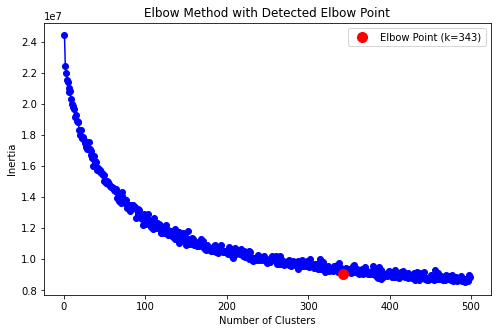

In [24]:
# 计算肘部点
# 使用曲率方法找到肘部点
# 曲率越大的点越有可能是肘部点
def calculate_curvature(x, y):
    """计算曲率
    
    曲率的计算原理:
    1. 一阶导数 dx, dy 表示曲线在每点的斜率变化率
    2. 二阶导数 d2y 表示曲线在每点的斜率的变化率的变化率
    3. 曲率公式 k = |y''| / (1 + y'^2)^(3/2) 其中:
       - y'' 是二阶导数,表示曲线弯曲程度
       - y' 是一阶导数,用于归一化
       - 3/2次方用于调整比例
    4. 曲率越大,表示曲线在该点弯曲程度越大
    """
    # 计算一阶导数(斜率变化率)
    dx = np.gradient(x)  # x方向的变化率
    dy = np.gradient(y)  # y方向的变化率
    
    # 计算二阶导数(斜率变化的变化率)
    d2y = np.gradient(dy)
    
    # 使用曲率公式: k = |y''| / (1 + y'^2)^(3/2)
    curvature = np.abs(d2y) / (1 + dy**2)**1.5
    return curvature

# 将cluster_range和inertia转换为numpy数组用于计算
x = np.array(list(cluster_range))
y = np.array(inertia)

# 计算曲率
curvature = calculate_curvature(x, y)

# 找到曲率最大的点
elbow_idx = np.argmax(curvature[1:-1]) + 1  # 排除首尾点
elbow_point = x[elbow_idx]

print(f"建议的肘部点（最佳聚类数）: {elbow_point}")

# 可视化肘部点
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b-', marker='o')
plt.plot(elbow_point, y[elbow_idx], 'ro', markersize=10, label=f'Elbow Point (k={elbow_point})')
plt.title('Elbow Method with Detected Elbow Point')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()


In [25]:
# 创建一个包含聚类数和对应曲率的列表
cluster_curvature = list(zip(x, curvature))

# 按曲率降序排序
sorted_clusters = sorted(cluster_curvature, key=lambda x: x[1], reverse=True)

print("聚类数量和对应的曲率（按曲率降序排列）:")
print("-" * 40)
print("聚类数\t\t曲率")
print("-" * 40)
for k, curv in sorted_clusters:
    print(f"{int(k)}\t\t{curv:.6f}")


聚类数量和对应的曲率（按曲率降序排列）:
----------------------------------------
聚类数		曲率
----------------------------------------
343		0.010010
310		0.000148
152		0.000080
175		0.000076
101		0.000036
263		0.000027
349		0.000021
145		0.000008
79		0.000006
324		0.000004
273		0.000002
456		0.000001
332		0.000001
238		0.000001
473		0.000001
459		0.000001
29		0.000001
277		0.000000
451		0.000000
375		0.000000
228		0.000000
232		0.000000
397		0.000000
305		0.000000
165		0.000000
183		0.000000
282		0.000000
466		0.000000
495		0.000000
276		0.000000
80		0.000000
70		0.000000
85		0.000000
87		0.000000
345		0.000000
307		0.000000
427		0.000000
486		0.000000
20		0.000000
434		0.000000
139		0.000000
63		0.000000
265		0.000000
351		0.000000
414		0.000000
224		0.000000
399		0.000000
315		0.000000
406		0.000000
52		0.000000
425		0.000000
338		0.000000
313		0.000000
272		0.000000
93		0.000000
223		0.000000
374		0.000000
252		0.000000
116		0.000000
404		0.000000
475		0.000000
218		0.000000
108		0.000000
174		0.000000
353

In [1]:
# Load grammar stats and code vectors
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load grammar stats
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/core_grammar_stats.json', 'r') as f:
    grammar_stats = json.load(f)

# Load code vectors from AST
code_vectors = np.load('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.npy') 

# Scale the vectors
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(code_vectors)

# Save scaled vectors
np.save('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/scaled_ast_vectors.npy', scaled_vectors)

# Perform k-means clustering with k=20
kmeans = KMeans(n_clusters=30, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_vectors)
cluster_centers = kmeans.cluster_centers_


In [7]:
top_20_patterns = sorted(grammar_stats['structure_counts'].items(), key=lambda x: x[1], reverse=True)[:20]
top_20_patterns

[('ROOT:VERB_OBJ:NOUN', 112476),
 ('ROOT:NOUN_OBJ:NOUN', 30214),
 ('ROOT:VERB_SUBJ:NOUN_OBJ:NOUN', 17604),
 ('ROOT:VERB_OBJ:PROPN', 10032),
 ('ROOT:VERB_SUBJ:PRON_OBJ:NOUN', 9416),
 ('ROOT:NOUN', 6656),
 ('ROOT:NOUN_OBJ:NOUN_MOD:ADJ', 5430),
 ('ROOT:PROPN_OBJ:NOUN', 4936),
 ('ROOT:VERB_SUBJ:NOUN', 3369),
 ('ROOT:NOUN_SUBJ:PRON_OBJ:NOUN', 3186),
 ('ROOT:NOUN_OBJ:PROPN', 3103),
 ('ROOT:NOUN_SUBJ:NOUN_OBJ:NOUN', 2751),
 ('ROOT:VERB_SUBJ:PROPN_OBJ:NOUN', 2733),
 ('ROOT:VERB_OBJ:NOUN_MOD:ADV', 2564),
 ('ROOT:NOUN_MOD:ADJ', 2417),
 ('ROOT:VERB_OBJ:PRON', 1928),
 ('ROOT:PROPN', 1548),
 ('ROOT:VERB_SUBJ:NOUN_OBJ:PROPN', 1484),
 ('ROOT:NOUN_SUBJ:NOUN', 973),
 ('ROOT:VERB_SUBJ:NOUN_OBJ:NOUN_MOD:ADV', 863)]

In [9]:

# Load cluster labels from file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/clustering_results.json', 'r') as f:
    clustering_results = json.load(f)
cluster_labels = np.array(clustering_results['cluster_labels'])

# Create mapping of data points to grammar patterns and clusters
pattern_cluster_counts = {}
for pattern, _ in top_20_patterns:
    for cluster in range(30):
        pair_key = (pattern, cluster)
        pattern_cluster_counts[pair_key] = 0

# Count occurrences of each pattern-cluster pair
total_examples = 0
for i, pattern_id in enumerate(grammar_stats['sentence_patterns']):
    # Convert pattern_id to actual pattern string
    pattern = grammar_stats['sentence_patterns'][pattern_id]
    if pattern in [p[0] for p in top_20_patterns]:
        cluster = cluster_labels[i]
        pattern_cluster_counts[(pattern, cluster)] += 1
        total_examples += 1

# Sort pattern-cluster pairs by count
sorted_pairs = sorted(pattern_cluster_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
print("\nTop pattern-cluster pairs by number of training examples:")
print("-" * 100)
print("Pattern\t\tCluster\t\tCount\t\tCumulative Coverage")
print("-" * 100)
num = 1
cumulative_count = 0
for (pattern, cluster), count in sorted_pairs:
    cumulative_count += count
    coverage = (cumulative_count / total_examples) * 100
    print(f"{num} {pattern[:30]:<30}\t{cluster:<10}\t{count:<10}\t{coverage:.2f}%")
    num += 1



Top pattern-cluster pairs by number of training examples:
----------------------------------------------------------------------------------------------------
Pattern		Cluster		Count		Cumulative Coverage
----------------------------------------------------------------------------------------------------
1 ROOT:VERB_OBJ:NOUN            	17        	54753     	24.48%
2 ROOT:VERB_OBJ:NOUN            	2         	15945     	31.61%
3 ROOT:NOUN_OBJ:NOUN            	17        	14834     	38.24%
4 ROOT:VERB_SUBJ:NOUN_OBJ:NOUN  	17        	8288      	41.94%
5 ROOT:VERB_OBJ:NOUN            	27        	8233      	45.62%
6 ROOT:VERB_OBJ:NOUN            	13        	5606      	48.13%
7 ROOT:VERB_OBJ:NOUN            	20        	5202      	50.46%
8 ROOT:VERB_OBJ:PROPN           	17        	4978      	52.68%
9 ROOT:VERB_SUBJ:PRON_OBJ:NOUN  	17        	4426      	54.66%
10 ROOT:NOUN_OBJ:NOUN            	2         	4351      	56.61%
11 ROOT:VERB_OBJ:NOUN            	26        	3708      	58.26%
12 ROOT:NO

In [63]:
# Save clustering results
clustering_results = {
    'cluster_labels': cluster_labels.tolist(),
    'cluster_centers': cluster_centers.tolist(),
}

# Save to file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/clustering_results.json', 'w') as f:
    json.dump(clustering_results, f, indent=2)


In [64]:
# Get top 100 pattern-cluster pairs
top_100_pairs = sorted_pairs[:100]

# Convert scaled vectors to tensor for efficient distance calculation
scaled_vectors_tensor = torch.tensor(scaled_vectors, device='cuda')
cluster_centers_tensor = torch.tensor(cluster_centers, device='cuda')

# Store results
representative_examples = []

# For each pattern-cluster pair
for (pattern, cluster), count in top_100_pairs:
    # Get indices of examples with this pattern and cluster
    indices = [i for i, pattern_id in enumerate(grammar_stats['sentence_patterns']) 
              if grammar_stats['sentence_patterns'][pattern_id] == pattern and cluster_labels[i] == cluster]
            
    if not indices:
        continue
        
    # Get vectors for these examples
    cluster_examples = scaled_vectors_tensor[indices]
    
    # Calculate distances to cluster center
    center = cluster_centers_tensor[cluster].unsqueeze(0)
    distances = torch.cdist(cluster_examples, center)
    
    # Find index of closest example
    min_dist_idx = torch.argmin(distances)
    min_dist = distances[min_dist_idx].item()
    original_idx = indices[min_dist_idx]
    
    representative_examples.append({
        'pattern': pattern,
        'cluster': int(cluster),
        'distance': float(min_dist),
        'index': int(original_idx)
    })

# Save results
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/representative_examples.json', 'w') as f:
    json.dump(representative_examples, f, indent=2)


In [4]:
import json
import numpy as np
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/core_grammar_stats.json', 'r') as f:
    grammar_stats = json.load(f)
    sentence_patterns = grammar_stats['sentence_patterns']

with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/clustering_results.json', 'r') as f:
    clustering_results = json.load(f)
    cluster_centers = clustering_results['cluster_centers']

ast_vectors = np.load('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/ast_vectors.npy')


In [7]:
# Load all necessary data and configurations
import os
import json
import re

# Load training data
file_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/train.jsonl'
train_data = []
with open(file_path, 'r') as f:
    for line in f:
        train_data.append(json.loads(line.strip()))

# Load code and comment tokens
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/tokenized_code_tokens_train.jsonl', 'r') as f:
    code_tokens_strs = json.load(f)

with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/tokenized_comment_tokens_train.jsonl', 'r') as f:
    nl_tokens_strs = json.load(f)

# Load further tokenized code data
tokens_output_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/code_tokens_further.jsonl"
code_tokens_further_data = []
with open(tokens_output_path, 'r', encoding='utf-8') as f:
    for line in f:
        json_obj = json.loads(line)
        code_tokens_further_data.append(json_obj['code_tokens_further'])

# Load unique symbolized tokens
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/docstring_tokens_unique.jsonl", 'r') as f:
    docstring_tokens_unique = json.load(f)
    for i, data in enumerate(train_data):
        data['docstring_tokens_unique'] = docstring_tokens_unique[i]

with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/code_tokens_unique.jsonl", 'r') as f:
    code_tokens_further_data_unique = json.load(f)

# Load student-teacher pairs
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/student_teachers_pairs.jsonl", 'r') as f:
    student_teacher_pairs = json.load(f)

# Load labeled examples info
idx_list = []
match_list = []
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api.jsonl", 'r') as f:
    for line in f:
        json_obj = json.loads(line.strip())
        idx_list.append(json_obj['idx'])
        match_list.append(json_obj['match'])

JSONDecodeError: Extra data: line 2 column 1 (char 2985)

In [20]:
# Find the student-teacher pair for student_idx 46309
target_pair = None
for pair in student_teacher_pairs:
    if pair['student_idx'] == 46309:
        target_pair = pair
        break

if target_pair:
    print("\n=== Teacher Examples ===")
    for i, teacher in enumerate(target_pair['teachers']):
        teacher_idx = teacher['teacher_idx']
        print(f"\nTeacher {i+1} (idx: {teacher_idx}):")
        print("\nComment Tokens:")
        from IPython.display import display
        display({
            'Comment Tokens': train_data[teacher_idx]['docstring_tokens_unique']
        })
        print("\nCode Tokens:")
        display({
            'Code Tokens': code_tokens_further_data_unique[teacher_idx]
        })
        
        # Find teacher's alignments
        teacher_ind = idx_list.index(teacher_idx)
        
        # Initialize list to store all alignments
        alignments = []
        
        # For each match pair in the match list
        for match_pair in match_list[teacher_ind]:
            # Get comment and code match indices
            comment_match = match_pair[0]
            code_match = match_pair[1]
            
            # Initialize lists for current pair's tokens
            current_comment_tokens = []
            current_code_tokens = []
            
            # Extract matched comment tokens using indices
            for i in range(0, len(comment_match), 2):
                start, end = comment_match[i], comment_match[i+1]
                tokens = nl_tokens_strs[teacher_idx][1:][start:end+1]
                for token in tokens:
                    clean_token = token.replace('Ġ', '')
                    current_comment_tokens.append(clean_token)
                    
            # Extract matched code tokens using indices
            for i in range(0, len(code_match), 2):
                start, end = code_match[i], code_match[i+1]
                tokens = code_tokens_strs[teacher_idx][1:][start:end+1]
                for token in tokens:
                    clean_token = token.replace('Ġ', '')
                    current_code_tokens.append(clean_token)
                    
            # Map current pair's tokens to new token lists
            docstring_tokens = train_data[teacher_idx]['docstring_tokens']
            code_tokens = code_tokens_further_data[teacher_idx]
            
            # Create mappings for current pair
            current_comment_map = {}
            current_code_map = {}
            
            # Map comment tokens for current pair
            doc_start_idx = 0
            for i, matched_token in enumerate(current_comment_tokens):
                for j in range(doc_start_idx, len(docstring_tokens)):
                    if matched_token in docstring_tokens[j]:
                        current_comment_map[f"{i}_{matched_token}"] = f"{j}_{docstring_tokens[j]}"
                        doc_start_idx = j + 1
                        break
                        
            # Map code tokens for current pair
            code_start_idx = 0
            for i, matched_token in enumerate(current_code_tokens):
                for j in range(code_start_idx, len(code_tokens)):
                    if matched_token in code_tokens[j]:
                        current_code_map[f"{i}_{matched_token}"] = f"{j}_{code_tokens[j]}"
                        code_start_idx = j + 1
                        break
                        
            # Extract indices from current mappings
            comment_indices = [int(v.split('_')[0]) for v in current_comment_map.values()]
            code_indices = [int(v.split('_')[0]) for v in current_code_map.values()]
            
            # Get corresponding unique symbolized tokens
            unique_docstring_tokens = train_data[teacher_idx]['docstring_tokens_unique']
            unique_code_tokens = code_tokens_further_data_unique[teacher_idx]
            comment_unique_tokens = [unique_docstring_tokens[idx] for idx in comment_indices]
            code_unique_tokens = [unique_code_tokens[idx] for idx in code_indices]
            
            # Create alignment dict for current pair
            alignment = {
                "comment_token": comment_unique_tokens,
                "code_token": code_unique_tokens
            }
            
            # Add to alignments list
            alignments.append(alignment)
            
        print("\nAlignments:")
        display({
            'Alignments': alignments
        })

    print("\n=== Student Example ===")
    print("\nComment Tokens:")
    display({
        'Comment Tokens': train_data[46309]['docstring_tokens_unique']
    })
    print("\nCode Tokens:")
    display({
        'Code Tokens': code_tokens_further_data_unique[46309]
    })
else:
    print("Could not find student-teacher pair for student_idx 46309")


=== Teacher Examples ===

Teacher 1 (idx: 200213):

Comment Tokens:


{'Comment Tokens': ['Blend',
  'a',
  'single',
  'model',
  '.▲1',
  'You',
  'should',
  'rarely',
  'be',
  'using',
  'this',
  'method',
  '.▲2',
  'Use',
  'ModelsPipeline',
  '.▲3',
  'blend',
  'instead',
  '.▲4']}


Code Tokens:


{'Code Tokens': ['def',
  'blend■1',
  '(■1',
  'self■1',
  ',■1',
  'proportion■1',
  '=■1',
  '0■1',
  '2',
  ',■2',
  'stratify■1',
  '=■2',
  'False',
  ',■3',
  'seed■1',
  '=■3',
  '100',
  ',■4',
  'indices■1',
  '=■4',
  'None■1',
  ')■1',
  ':■1',
  'if■1',
  'self■2',
  '.■1',
  'use■1',
  '_■1',
  'cache■1',
  ':■2',
  'pd■1',
  'ict■1',
  '=■5',
  '{',
  "'■1",
  'proportion■2',
  "'■2",
  ':■3',
  'proportion■3',
  ',■5',
  "'■3",
  'stratify■2',
  "'■4",
  ':■4',
  'stratify■3',
  ',■6',
  "'■5",
  'seed■2',
  "'■6",
  ':■5',
  'seed■3',
  ',■7',
  "'■7",
  'indices■2',
  "'■8",
  ':■6',
  'indices■3',
  '}',
  'if■2',
  'indices■4',
  'is',
  'not■1',
  'None■2',
  ':■7',
  'pd■2',
  'ict■2',
  '[■1',
  "'■9",
  'train■1',
  '_■2',
  'index■1',
  "'■10",
  ']■1',
  '=■6',
  'np■1',
  '_■3',
  'hash■1',
  '(■2',
  'indices■5',
  '[■2',
  '0■2',
  ']■2',
  ')■2',
  'pd■3',
  'ict■3',
  '[■3',
  "'■11",
  'test■1',
  '_■4',
  'index■2',
  "'■12",
  ']■3',
  '=■7',
  'np■2',


Alignments:


{'Alignments': [{'comment_token': ['Blend', 'blend', '.▲4'],
   'code_token': ['blend■1',
    'proportion■1',
    'stratify■1',
    'stratify■2',
    'seed■2',
    'proportion■4',
    'stratify■4',
    'stratify■5',
    'seed■4',
    'seed■5']},
  {'comment_token': ['single', 'model'],
   'code_token': ['indices■1',
    'use■1',
    'cache■1',
    'indices■2',
    'indices■3',
    'indices■4',
    'indices■5',
    'train■2',
    '_■8',
    'test■4',
    '_■14',
    'train■10',
    'train■11',
    'test■6',
    'test■7',
    'stratify■4',
    '_■19',
    'train■12',
    'y■7',
    '_■28',
    'train■13',
    'Data■2',
    'set■6',
    '(■20',
    '_■39',
    'train■18',
    ',■25',
    'y■10',
    '_■40',
    '_■41',
    'test■17',
    ')■20']}]}


Teacher 2 (idx: 56795):

Comment Tokens:


{'Comment Tokens': ['Determine',
  'the▲1',
  'start',
  'and▲1',
  'end',
  'columns',
  'and▲2',
  'names',
  'of',
  'the▲2',
  'fields',
  '.']}


Code Tokens:


{'Code Tokens': ['def',
  'parse',
  '_■1',
  'fields■1',
  '(■1',
  'self■1',
  ')■1',
  ':■1',
  'rule■1',
  '=■1',
  'self■2',
  '.■1',
  't■1',
  '[■1',
  "'■1",
  'top',
  'rule■2',
  "'■2",
  ']■1',
  '.■2',
  'r■1',
  'strip■1',
  '(■2',
  ')■2',
  'if■1',
  'not■1',
  '(■3',
  'rule■3',
  'self■3',
  '.■3',
  't■2',
  '[■2',
  "'■3",
  'mid',
  'rule■4',
  "'■4",
  ']■2',
  '.■4',
  'r■2',
  'strip■2',
  '(■4',
  ')■3',
  'and■1',
  'rule■5',
  'self■4',
  '.■5',
  't■3',
  '[■3',
  "'■5",
  'bot',
  'rule■6',
  "'■6",
  ']■3',
  '.■6',
  'r■3',
  'strip■3',
  '(■5',
  ')■4',
  ')■5',
  ':■2',
  'raise■1',
  'Parse■1',
  'Error■1',
  '(■6',
  'Table',
  'rules',
  'differ',
  'from',
  'each',
  'other',
  'check',
  'white',
  'space',
  ')■6',
  'names■1',
  '=■2',
  'self■5',
  '.■7',
  't■4',
  '[■4',
  "'■7",
  'fields■2',
  "'■8",
  ']■4',
  '.■8',
  'split■1',
  '(■7',
  ')■7',
  'n■1',
  'fields■3',
  '=■3',
  'len■1',
  '(■8',
  'rule■7',
  '.■9',
  'split■2',
  '(■9',


Alignments:


{'Alignments': [{'comment_token': ['start'],
   'code_token': ['starts', 'start■1', 'start■2']},
  {'comment_token': ['end'], 'code_token': ['end']},
  {'comment_token': ['names'],
   'code_token': ['names■1',
    '=■2',
    'self■5',
    '.■7',
    't■4',
    '[■4',
    "'■7",
    'fields■2',
    "'■8",
    ']■4',
    '.■8',
    'split■1',
    '(■7',
    ')■7',
    'names■2',
    'names■3',
    'names■4']},
  {'comment_token': ['fields'],
   'code_token': ['fields■1',
    'not■1',
    'fields■2',
    'n■1',
    'fields■3',
    'fields■4',
    'fields■5',
    'n■3',
    'fields■6',
    'fields■7',
    'if■3',
    'field■6',
    'is■3',
    '_■9',
    'field■8',
    'field■9',
    'fields■8',
    'is■5',
    '_■13',
    'field■12',
    'fields■9',
    'fields■10']},
  {'comment_token': ['Determine'],
   'code_token': ['parse',
    'rule■1',
    'top',
    'rule■2',
    'r■1',
    'strip■1',
    'if■1',
    'not■1',
    'rule■3',
    'mid',
    'rule■4',
    'r■2',
    'strip■2',
    'ru


Teacher 3 (idx: 123328):

Comment Tokens:


{'Comment Tokens': ['Ensure', 'zone', 'is', 'booted']}


Code Tokens:


{'Code Tokens': ['def',
  'booted■1',
  '(■1',
  'name■1',
  ',■1',
  'single■1',
  '=■1',
  'False■1',
  ')■1',
  ':■1',
  'ret■1',
  '=■2',
  '{■1',
  "'■1",
  'name■2',
  "'■2",
  ':■2',
  'name■3',
  ',■2',
  "'■3",
  'changes■1',
  "'■4",
  ':■3',
  '{■2',
  '}■1',
  ',■3',
  "'■5",
  'result■1',
  "'■6",
  ':■4',
  'None',
  ',■4',
  "'■7",
  'comment■1',
  "'■8",
  ':■5',
  "'■9",
  "'■10",
  '}■2',
  'zones■1',
  '=■3',
  '_■1',
  'salt■1',
  '_■2',
  '[■1',
  "'■11",
  'zone■1',
  'adm■1',
  'list',
  "'■12",
  ']■1',
  '(■2',
  'installed■1',
  '=■4',
  'True■1',
  ')■2',
  'if■1',
  'name■4',
  'in■1',
  'zones■2',
  ':■6',
  'if■2',
  'zones■3',
  '[■2',
  'name■5',
  ']■2',
  '[■3',
  "'■13",
  'state■1',
  "'■14",
  ']■3',
  "'■15",
  'running',
  "'■16",
  ':■7',
  'ret■2',
  '[■4',
  "'■17",
  'result■2',
  "'■18",
  ']■4',
  '=■5',
  'True■2',
  'ret■3',
  '[■5',
  "'■19",
  'comment■2',
  "'■20",
  ']■5',
  '=■6',
  "'■21",
  'Zone■1',
  '0■1',
  'already',
  'booted■


Alignments:


{'Alignments': [{'comment_token': ['booted'],
   'code_token': ['booted■1',
    'booted■2',
    'booted■3',
    'booted■4',
    'False■2',
    'Failed',
    'to',
    'boot■2']},
  {'comment_token': ['zone'],
   'code_token': ['name■1',
    'name■2',
    'name■3',
    'zones■1',
    'salt■1',
    'salt■2',
    'zone■3',
    'adm■3',
    'name■7',
    '.■2',
    'name■9',
    'zones■4',
    'zones■5',
    'name■12',
    'zone■8',
    'instead',
    'format■5',
    'result■5',
    'False■3',
    'comment■8',
    '.■8',
    'comment■9']},
  {'comment_token': ['Ensure'],
   'code_token': ['if■1',
    'if■2',
    'running',
    'else■1',
    'if■3',
    'not■1',
    'if■4',
    'else■2',
    'else■3']}]}


=== Student Example ===

Comment Tokens:


{'Comment Tokens': ['create', 'a', 'gffutils', 'DB']}


Code Tokens:


{'Code Tokens': ['def',
  'get',
  '_■1',
  'gt■1',
  'f■1',
  '_■2',
  'db■1',
  '(■1',
  'gt■2',
  'f■2',
  ',■1',
  'in■1',
  '_■3',
  'memory■1',
  '=■1',
  'False',
  ')■1',
  ':■1',
  'db■2',
  '_■4',
  'file■1',
  '=■2',
  'gt■3',
  'f■3',
  '+■1',
  "'■1",
  'db■3',
  "'■2",
  'if■1',
  'gt■4',
  'f■4',
  '.■1',
  'ends',
  'with',
  '(■2',
  "'■3",
  'gz',
  "'■4",
  ')■2',
  ':■2',
  'db■4',
  '_■5',
  'file■2',
  '=■3',
  'gt■5',
  'f■5',
  '[',
  ':■3',
  '-',
  '3',
  ']',
  '+■2',
  "'■5",
  'db■5',
  "'■6",
  'if■2',
  'file■3',
  '_■6',
  'exists■1',
  '(■3',
  'db■6',
  '_■7',
  'file■4',
  ')■3',
  ':■4',
  'return■1',
  'g■1',
  'ff■1',
  'utils■1',
  '.■2',
  'FeatureD■1',
  'B■1',
  '(■4',
  'db■7',
  '_■8',
  'file■5',
  ')■4',
  'db■8',
  '_■9',
  'file■6',
  '=■4',
  "'■7",
  'memory■2',
  "'■8",
  'if■3',
  'in■2',
  '_■10',
  'memory■3',
  'else■1',
  'db■9',
  '_■11',
  'file■7',
  'if■4',
  'in■3',
  '_■12',
  'memory■4',
  'or',
  'not■1',
  'file■8',
  '_■

In [9]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/code_tokens_unique.json", 'r') as f:
    code_tokens_further_data_unique = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/code_tokens_unique.json'

In [6]:
print(code_tokens_further_data_unique[175026])

NameError: name 'code_tokens_further_data_unique' is not defined

In [4]:
import json
import random

# Read sorted labelling sample API student conf file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api_student_conf.jsonl', 'r') as f:
    samples = [json.loads(line) for line in f]

# Randomly select 100 samples from index 50 onwards
selected_samples = random.sample(samples[50:], 100)

# Read student-teacher pairs file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/student_teachers_pairs.jsonl', 'r') as f:
    student_teacher_pairs = [json.loads(line) for line in f]

# Create student-teacher confidence map
student_teacher_conf_map = {}
for pair in student_teacher_pairs:
    student_idx = pair['student_idx']
    teacher_confs = [t['confidence'] for t in pair['teachers']]
    student_teacher_conf_map[student_idx] = sum(teacher_confs) / len(teacher_confs)

# Print student idx and average teacher confidence for each pair
for sample in selected_samples:
    student_idx = sample['idx']
    if student_idx in student_teacher_conf_map:
        avg_conf = student_teacher_conf_map[student_idx]
        print(f"\nStudent idx: {student_idx}")
        print(f"Average teacher confidence: {avg_conf:.4f}")



Student idx: 3388
Average teacher confidence: 0.5726

Student idx: 33265
Average teacher confidence: 0.5521

Student idx: 50670
Average teacher confidence: 0.6033

Student idx: 21187
Average teacher confidence: 0.6491

Student idx: 9963
Average teacher confidence: 0.5958

Student idx: 56726
Average teacher confidence: 0.5609

Student idx: 32336
Average teacher confidence: 0.5932

Student idx: 29701
Average teacher confidence: 0.5753

Student idx: 67111
Average teacher confidence: 0.5946

Student idx: 48659
Average teacher confidence: 0.5420

Student idx: 26858
Average teacher confidence: 0.5457

Student idx: 70685
Average teacher confidence: 0.5499

Student idx: 45676
Average teacher confidence: 0.5719

Student idx: 35148
Average teacher confidence: 0.5780

Student idx: 45663
Average teacher confidence: 0.5205

Student idx: 39183
Average teacher confidence: 0.6498

Student idx: 18801
Average teacher confidence: 0.5119

Student idx: 66094
Average teacher confidence: 0.6246

Student idx

In [5]:
# Append selected samples to output file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api.jsonl', 'a') as f:
    for sample in selected_samples:
        f.write(json.dumps(sample) + '\n')

print(f"\nAppended {len(selected_samples)} samples to sorted_labelling_sample_api.jsonl")


Appended 100 samples to sorted_labelling_sample_api.jsonl
